In [47]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime
from utils.neural_network import train_nn, get_device

from utils.load_data import load_data, load_gt_data
from utils.preprocessing_v2 import Preprocessing, get_gt_diff_logs
from utils.results import bootstrap_ensemble, interactive_plot_predictions, summarize_results, measure_smoothness_with_df
import torch
import torch.nn as nn

from postprocessing.arima import smooth_nn_predictions_with_arima_auto, smooth_nn_predictions_with_arima


TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

## Loading and Preprocessing Data

### Loading Google Trends

In [48]:
TRAIN_PROPORTION = 0.9
MODE = "diff" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction

In [49]:
data, all_gdps, all_gts = load_data()
data['country'].unique()

array(['Switzerland', 'Germany', 'United Kingdom', 'Japan', 'Canada',
       'Korea', 'United States'], dtype=object)

In [50]:
preprocessor = Preprocessing(epsilon=EPS, gdp_diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)

X_train, y_train, X_valid, y_valid, x_high_freq = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, 
                                                                  mode=MODE,
                                                                  take_log_diff_gdp=True,
                                                                  gt_trend_removal=False, 
                                                                  keep_pca_components=180, 
                                                                  noisy_data_stds=[0.001, 0.005, 0.01], 
                                                                  add_encoded_month=False, 
                                                                  gt_data_transformations=[get_gt_diff_logs], other_params={'plot_pca': False})

X_train shape : (1780, 180)
X_valid shape : (53, 180)
y_train shape : (1780,)
y_valid shape : (53,)
X_high_freq shape : (1547, 180)


## Simple Prediction Model

Using mps device


100%|██████████| 100/100 [00:00<00:00, 100.83it/s]


Final training loss: 0.01411503367125988
Final validation loss: 0.49500030279159546
Final validation R^2: 0.341994984856945


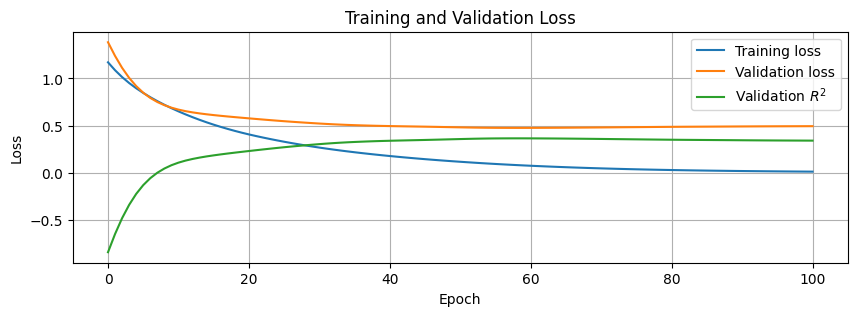

Best r squared: 0.36623771440346997 at epoch 58


In [51]:
model, training_loss, validation_loss, validation_r_squared, mse_losses = train_nn(X_train, 
                                                                       y_train, 
                                                                       X_valid, 
                                                                       y_valid, 
                                                                       num_epochs=100, 
                                                                       learning_rate=1e-4, 
                                                                       weight_decay=1e-2, 
                                                                       verbose=True,
                                                                       seed=SEED)

# Compute best r squared with epoch
best_r_squared = max(validation_r_squared)
best_epoch = validation_r_squared.index(best_r_squared)

print(f"Best r squared: {best_r_squared} at epoch {best_epoch}")

## High frequency predictions

In [52]:
# Predict for the high frequency data
device = get_device(False)
y_pred_high_freq = model(torch.tensor(x_high_freq, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
y_pred_high_freq_country = pd.DataFrame({'date': preprocessor.dates_high_freq, 'country': preprocessor.country_high_freq, 'y_pred': y_pred_high_freq})

In [53]:
# Get the true GDPs
country_train = preprocessor.country_train
country_valid = preprocessor.country_valid
all_true_gdps_country = np.concatenate([y_train, y_valid], axis=0)
all_dates = pd.concat([preprocessor.dates_train, preprocessor.dates_valid], axis=0)
all_true_gdps_country = pd.DataFrame({'date': all_dates, 'country': np.concatenate([country_train, country_valid], axis=0), 'y_true': np.concatenate([y_train, y_valid], axis=0)})

In [54]:
# Set the predicions to be plotted
predictions = y_pred_high_freq_country

# Add the true gdp for the points that we have
predictions = predictions.merge(all_true_gdps_country, on=["date", "country"], how="left")

# Remove duplicates
predictions = predictions.drop_duplicates(subset=["date", "country"])

# Rename y_pred to y_pred_high_freq
predictions = predictions.rename(columns={"y_pred": "y_pred_high_freq"})

In [55]:
# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions[predictions["country"] == selected_country]
    cutoff_date = predictions['date'].quantile(TRAIN_PROPORTION)
    non_nans = filtered_data["y_true"].notna()
    y_trues = filtered_data["y_true"][non_nans]
    plt.figure(figsize=(15, 5))
    plt.plot(filtered_data["date"], filtered_data["y_pred_high_freq"], label="Predicted")
    plt.plot(filtered_data["date"][non_nans], y_trues, label="True")
    #plt.fill_between(filtered_data["date"], filtered_data["y_pred_high_freq"] - 3 * filtered_data["stdv"], filtered_data["y_pred_high_freq"] + 3 * filtered_data["stdv"], alpha=0.2, color="blue")
    plt.title(f"High frequency predictions vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({TRAIN_PROPORTION}%)')
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
countries.sort()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Japan', 'Korea', 'Switze…

<function __main__.plot_by_country(selected_country)>

In [56]:
# Compute the smoothness of the predictions
predictions2 = predictions.copy()
predictions2.rename(columns={"y_pred_high_freq": "data"}, inplace=True)
smoothness_results = measure_smoothness_with_df(predictions2)
print(f"Smoothness results: {smoothness_results}")

Smoothness results: [0.7254963026733993, 0.39396257056629513, 0.37390648975465746]


## Apply ARIMA smoothing

In [57]:
p = 1
d = 1
q = 1
adjusted_predictions = smooth_nn_predictions_with_arima(predictions, p, d, q)

In [58]:
def plot_by_country(selected_country):
    adjusted_filtered_data = adjusted_predictions[adjusted_predictions["country"] == selected_country]
    filtered_data = predictions[predictions["country"] == selected_country]
    cutoff_date = predictions['date'].quantile(TRAIN_PROPORTION)
    non_nans = filtered_data["y_true"].notna()
    y_trues = filtered_data["y_true"][non_nans]
    plt.figure(figsize=(15, 5))
    plt.plot(filtered_data["date"], filtered_data["y_pred_high_freq"], label="Predicted", alpha=0.5)
    plt.plot(adjusted_filtered_data["date"], adjusted_filtered_data["y_pred_high_freq"], label="Adjusted Predicted")
    plt.plot(filtered_data["date"][non_nans], y_trues, label="True")
    plt.title(f"High frequency predictions vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({TRAIN_PROPORTION}%)')
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [59]:
# Plot the adjusted predictions
interact(plot_by_country, selected_country=dropdown)

interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Japan', 'Korea', 'Switze…

<function __main__.plot_by_country(selected_country)>

In [60]:
# Compute the smoothness results
adjusted_predictions2 = adjusted_predictions.copy()
adjusted_predictions2.rename(columns={"y_pred_high_freq": "data"}, inplace=True)
smoothness_results_adjusted = measure_smoothness_with_df(adjusted_predictions2)
print(f"Smoothness results adjusted: {smoothness_results_adjusted}")

Smoothness results adjusted: [0.1623390408747504, 0.13992597907644339, 0.2612955263618233]


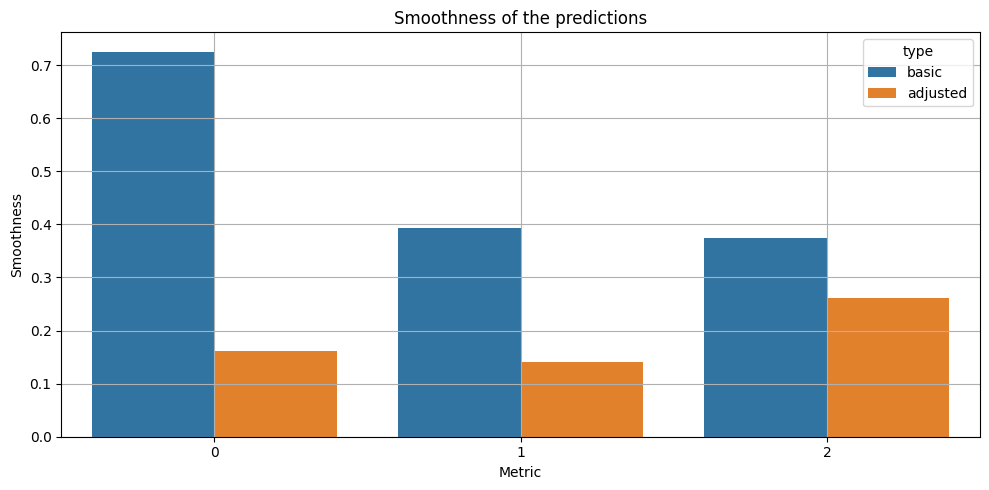

In [61]:
# Plot the results between the basic and adjusted predictions
all_smoothness_results = pd.DataFrame({'basic': smoothness_results, 'adjusted': smoothness_results_adjusted})

# I want one x per metric, not
all_smoothness_results = all_smoothness_results.reset_index().melt(id_vars='index', var_name='type', value_name='smoothness')

# Plot the results
plt.figure(figsize=(10, 5))
sns.barplot(x='index', y='smoothness', hue='type', data=all_smoothness_results)
plt.title("Smoothness of the predictions")
plt.xlabel("Metric")
plt.ylabel("Smoothness")
plt.grid(True)
plt.tight_layout()
plt.show()

In [62]:
# Difference between the smoothness results
percentage_ratios = [smoothness_results[i] / smoothness_results_adjusted[i]   for i in range(len(smoothness_results))]
print(f"Smoothness ratios: {percentage_ratios}")

Smoothness ratios: [4.469019274501826, 2.8155069785223246, 1.4309716471643628]
